In [56]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Convolution2D,MaxPooling2D,Flatten,BatchNormalization,Activation,Conv2D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping 
from keras import optimizers, regularizers, Model
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.callbacks import ModelCheckpoint

# Utility
import os
import pandas as pd
from os import listdir
from os.path import isfile, join 
import numpy as np
import itertools
import random
from collections import Counter
from glob import iglob
import seaborn as sn
import pickle

# Import OpenCV
import cv2
 
# Ignore warning
import warnings
warnings.filterwarnings('ignore')

### Model Setting

In [57]:
IMAGE_SIZE = (256,256)
INPUT_SHAPE = (256,256,3)

BATCH_SIZE = 12
EPOCHS = 20
STEP_PER_EPOCHS = 50

### Read Image Dataset

In [58]:
base_dir = 'dataset_v2'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
predict_dir = os.path.join(base_dir, 'predict')

### Creating objects for image augmentations

In [59]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=True,
                                   rotation_range=90)
 
test_datagen = ImageDataGenerator(rescale=1./255)

 
train_generator = train_datagen.flow_from_directory(train_dir,
                            target_size=IMAGE_SIZE,
                            batch_size=BATCH_SIZE,
                            class_mode='categorical')
 
test_generator = test_datagen.flow_from_directory(
        directory=test_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False)

Found 1890 images belonging to 5 classes.
Found 418 images belonging to 5 classes.


### Setup model layers

In [60]:
model = Sequential()

# Step 1 - Convolution
model.add(Conv2D(32, (3, 3), input_shape = INPUT_SHAPE, activation = 'relu'))

# Step 2 - Pooling
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

# Adding a second convolutional layer
model.add(Conv2D(32, (3, 3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2,2)))
model.add(BatchNormalization())

# Adding a third convolutional layer
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(BatchNormalization())

# Adding a fourth convolutional layer
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Step 3 - Flattening
model.add(Flatten())   
# Step 4 - Full connection
model.add(BatchNormalization())
model.add(Dense(units = 1024, activation = 'relu'))

model.add(Dense(units = 5, activation = 'softmax'))
 

In [61]:
optimizer = optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Fit Model

In [62]:
STEP_PER_EPOCHS = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = test_generator.n//test_generator.batch_size

model_history = model.fit(train_generator,steps_per_epoch= STEP_PER_EPOCHS,
                    epochs=EPOCHS, validation_data=test_generator, validation_steps=STEP_SIZE_VALID,
                    callbacks=[EarlyStopping(monitor='loss', patience=5)])

Epoch 1/20
157/157 [==============================] - 264s 2s/step - loss: 1.4943 - accuracy: 0.4989 - val_loss: 1.8334 - val_accuracy: 0.2108
Epoch 2/20
157/157 [==============================] - 270s 2s/step - loss: 1.2502 - accuracy: 0.5543 - val_loss: 2.1024 - val_accuracy: 0.2574
Epoch 3/20
157/157 [==============================] - 281s 2s/step - loss: 1.1969 - accuracy: 0.5857 - val_loss: 1.6613 - val_accuracy: 0.4314
Epoch 4/20
157/157 [==============================] - 296s 2s/step - loss: 1.0916 - accuracy: 0.6171 - val_loss: 1.3591 - val_accuracy: 0.5392
Epoch 5/20
157/157 [==============================] - 317s 2s/step - loss: 0.9986 - accuracy: 0.6539 - val_loss: 1.4888 - val_accuracy: 0.5539
Epoch 6/20
157/157 [==============================] - 302s 2s/step - loss: 0.9388 - accuracy: 0.6794 - val_loss: 1.2286 - val_accuracy: 0.5588
Epoch 7/20
157/157 [==============================] - 287s 2s/step - loss: 0.8977 - accuracy: 0.6752 - val_loss: 1.6863 - val_accuracy: 0.5319

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 127, 127, 32)      128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 125, 125, 32)      128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 123, 123, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 61, 61, 64)       

### Model Accuracy and Loss Plots

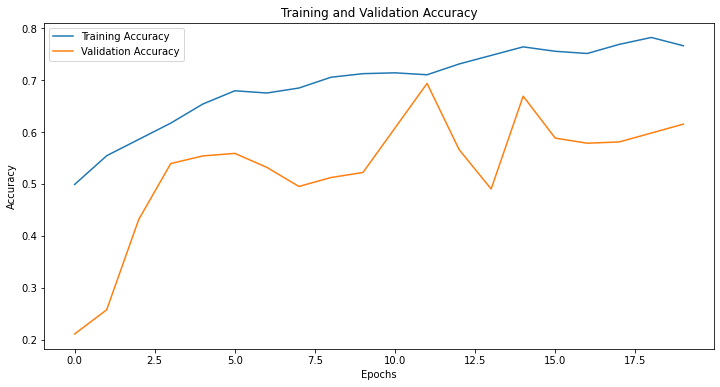

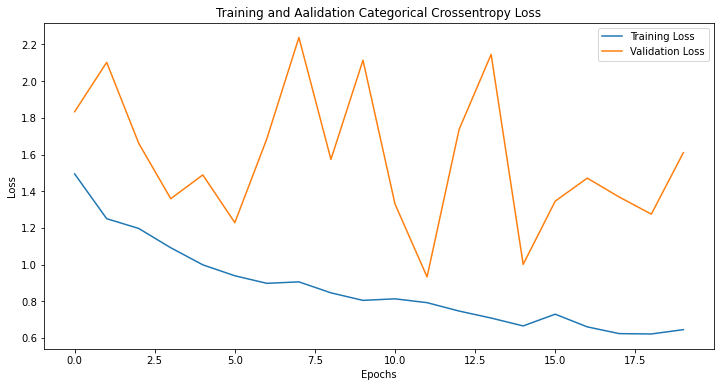

In [64]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)

def model_performance_plot(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Training Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Validation Accuracy')
    plt.legend()
  

    plt.figure()
    plt.xlabel('Epochs')
    plt.title('Training and Aalidation Categorical Crossentropy Loss')
    plt.plot(hist['epoch'], hist['loss'],label='Training Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


model_performance_plot(model_history)

### Evaluate Test Dataset

In [65]:
loss, accuracy = model.evaluate_generator(test_generator, steps=test_generator.samples//test_generator.batch_size)

In [66]:
print("Test dataset Accuracy: %f and Loss: %f" % (accuracy,loss))

Test dataset Accuracy: 0.615196 and Loss: 1.610147


### Model Classification and Confusion Matrix

In [67]:
Y_pred = model.predict_generator(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

In [68]:
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names)) 

              precision    recall  f1-score   support

   cardboard       0.82      0.86      0.84       101
       glass       0.58      0.61      0.59        80
       metal       0.38      0.82      0.52        65
       paper       0.85      0.23      0.36        95
     plastic       0.73      0.58      0.65        77

    accuracy                           0.61       418
   macro avg       0.67      0.62      0.59       418
weighted avg       0.69      0.61      0.60       418



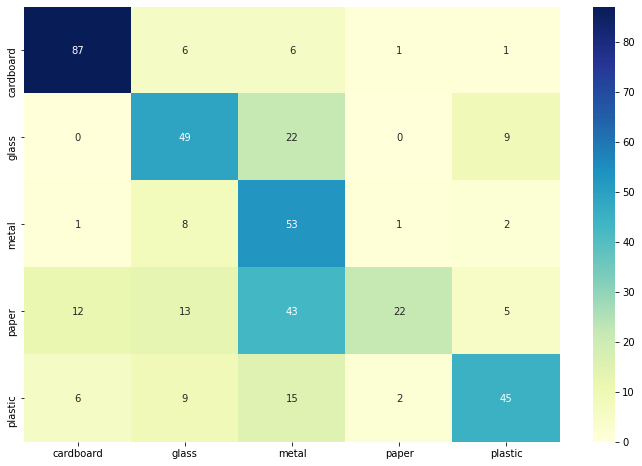

In [69]:
conf_mat = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(conf_mat, index = target_names, columns = target_names)
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

### Predict New Image

In [70]:
class_mapping = {v:k for k,v in train_generator.class_indices.items()}

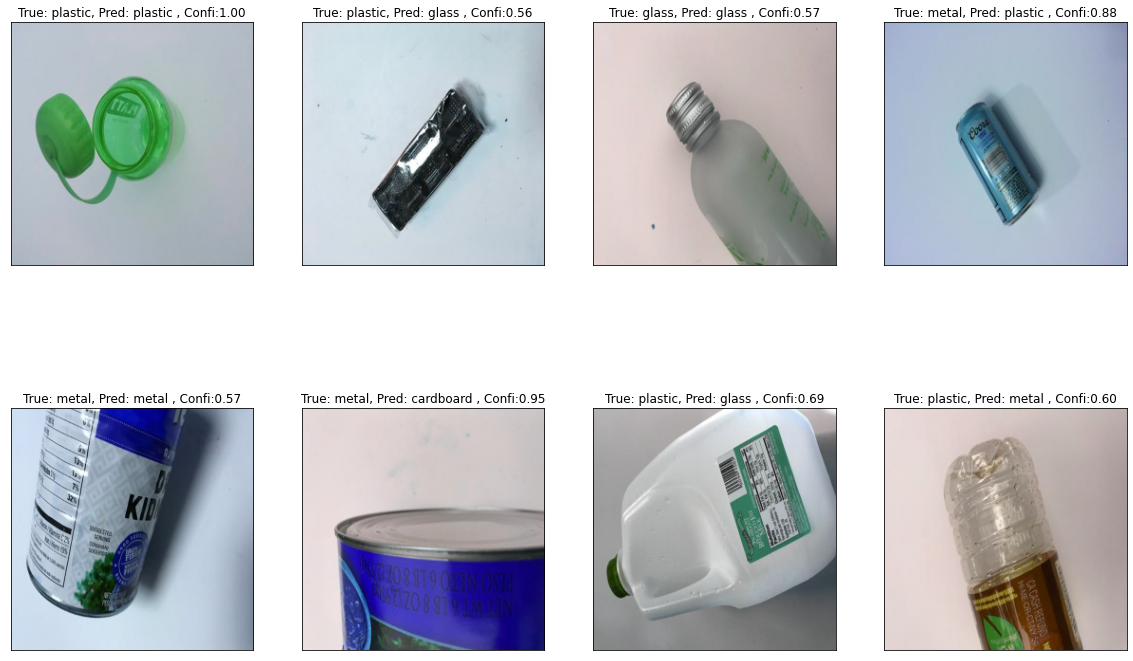

In [71]:
def image_type(filename):
    
    if "glass" in filename:
        return 'glass'
    elif "metal" in filename:
        return 'metal'
    elif "paper" in filename:
        return 'paper'
    elif "plastic" in filename:
        return 'plastic'
    elif "cardboard" in filename:
        return 'cardboard'
    

def plot_predicted_label(nrows, ncols,onlyfiles):
    fig, axes = plt.subplots(nrows, ncols,figsize=(20, 13))
    
    rs = np.random.choice(len(onlyfiles),nrows*ncols,replace=False)
    
    for i, ax in zip(rs, axes.flat):
        img = cv2.imread(os.path.join(predict_dir, onlyfiles[i]))
        true_type = image_type(onlyfiles[i])
        img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1])) 
        img = img /255
         
        probabilities = model.predict(np.asarray([img]))[0]
        class_idx = np.argmax(probabilities)
            
        title = 'True: %s, Pred: %s , Confi:%0.2f' % (true_type,class_mapping[class_idx],probabilities[class_idx])
        ax.imshow(img, cmap='binary')
        ax.set_title(title)
         
        ax.set_xticks([])
        ax.set_yticks([])

        
num_rows = 2
num_cols = 4

# load image path to predict
onlyfiles = [f for f in listdir(predict_dir) if isfile(join(predict_dir, f))]

plot_predicted_label(num_rows, num_cols,onlyfiles);

### Save Model

In [72]:
model.save('CNNModel.h5')